In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle
import time 
import sys

import import_ipynb
import VariationalAutoencoderModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
importing Jupyter notebook from VariationalAutoencoderModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

# Philips Baby Monitor Data Pre-Processing

In [3]:
# Benign traffic

pb_benign = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_pb_benign = pb_benign.copy(deep=True)

columns = list(df_pb_benign.columns)
chosen_columns = []
for column in columns:
    if column.find('L5') != -1:
        chosen_columns.append(column)

df_pb_benign = pd.DataFrame(df_pb_benign, columns = chosen_columns)        
        
# Mirai

pb_mirai_ack = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/mirai/ack.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_ack = pb_mirai_ack.copy(deep=True)
df_pb_mirai_ack = pd.DataFrame(df_pb_mirai_ack, columns = chosen_columns)

pb_mirai_scan = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/mirai/scan.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_scan = pb_mirai_scan.copy(deep=True)
df_pb_mirai_scan = pd.DataFrame(df_pb_mirai_scan, columns = chosen_columns)

pb_mirai_syn = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/mirai/syn.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_syn = pb_mirai_syn.copy(deep=True)
df_pb_mirai_syn = pd.DataFrame(df_pb_mirai_syn, columns = chosen_columns)

pb_mirai_udp = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/mirai/udp.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_udp = pb_mirai_udp.copy(deep=True)
df_pb_mirai_udp = pd.DataFrame(df_pb_mirai_udp, columns = chosen_columns)

pb_mirai_udpplain = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/mirai/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_udpplain = pb_mirai_udpplain.copy(deep=True)
df_pb_mirai_udpplain = pd.DataFrame(df_pb_mirai_udpplain, columns = chosen_columns)

# Bashlite

pb_bashlite_combo = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/gafgyt/combo.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_combo = pb_bashlite_combo.copy(deep=True)
df_pb_bashlite_combo = pd.DataFrame(df_pb_bashlite_combo, columns = chosen_columns)

pb_bashlite_junk = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/gafgyt/junk.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_junk = pb_bashlite_junk.copy(deep=True)
df_pb_bashlite_junk = pd.DataFrame(df_pb_bashlite_junk, columns = chosen_columns)

pb_bashlite_scan = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/gafgyt/scan.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_scan = pb_bashlite_scan.copy(deep=True)
df_pb_bashlite_scan = pd.DataFrame(df_pb_bashlite_scan, columns = chosen_columns)

pb_bashlite_udp = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/gafgyt/udp.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_udp = pb_bashlite_udp.copy(deep=True)
df_pb_bashlite_udp = pd.DataFrame(df_pb_bashlite_udp, columns = chosen_columns)

pb_bashlite_tcp = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/gafgyt/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_tcp = pb_bashlite_tcp.copy(deep=True)
df_pb_bashlite_tcp = pd.DataFrame(df_pb_bashlite_tcp, columns = chosen_columns)

In [4]:
scaler = MinMaxScaler()
df_pb_benign_norm = scaler.fit_transform(df_pb_benign)

df_pb_miraiack_norm = scaler.fit_transform(df_pb_mirai_ack)
df_pb_miraiscan_norm = scaler.fit_transform(df_pb_mirai_scan)
df_pb_miraisyn_norm = scaler.fit_transform(df_pb_mirai_syn)
df_pb_miraiudp_norm = scaler.fit_transform(df_pb_mirai_udp)
df_pb_miraiudpplain_norm = scaler.fit_transform(df_pb_mirai_udpplain)

df_pb_bashlitecombo_norm = scaler.fit_transform(df_pb_bashlite_combo)
df_pb_bashlitejunk_norm = scaler.fit_transform(df_pb_bashlite_junk)
df_pb_bashlitescan_norm = scaler.fit_transform(df_pb_bashlite_scan)
df_pb_bashliteudp_norm = scaler.fit_transform(df_pb_bashlite_udp)
df_pb_bashlitetcp_norm = scaler.fit_transform(df_pb_bashlite_tcp)

# Variational Autoencoder - Attack Detection

## Model

In [5]:
# Train set

len_benign = len(df_pb_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train_VAE = df_pb_benign_norm[:len_benign_train]

# Test set - 30% benign and the rest is attack

X_test_benign = df_pb_benign_norm[len_benign_train:]

len_attack_test = len(X_test_benign)
X_test_mirai_ack = df_pb_miraiack_norm
X_test_mirai_scan = df_pb_miraiscan_norm
X_test_mirai_syn = df_pb_miraisyn_norm
X_test_mirai_udp = df_pb_miraiudp_norm
X_test_mirai_udpplain = df_pb_miraiudpplain_norm
X_test_bashlite_combo = df_pb_bashlitecombo_norm
X_test_bashlite_junk = df_pb_bashlitejunk_norm
X_test_bashlite_scan = df_pb_bashlitescan_norm
X_test_bashlite_tcp = df_pb_bashlitetcp_norm
X_test_bashlite_udp = df_pb_bashliteudp_norm

X_test_VAE = np.concatenate([X_test_benign, X_test_mirai_ack, X_test_mirai_scan, X_test_mirai_syn, X_test_mirai_udp,
                             X_test_mirai_udpplain, X_test_bashlite_combo, X_test_bashlite_junk, X_test_bashlite_scan,
                             X_test_bashlite_tcp, X_test_bashlite_udp])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0

In [6]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [7]:
# Parameters

original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

epochs = 100
learning_rate = 0.0001
batch_size = 65
anomaly_threshold = 0.030
number_features = 23

In [8]:
# Encoder

inputs, encoder, z_var, z_mean = VariationalAutoencoderModel.vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    VariationalAutoencoderModel.sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 23)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 11)           264         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 7)            84          dense[0][0]                      
__________________________________________________________________________________________________
z_var (Dense)                   (None, 7)            84          dense[0][0]                      
____________________________________________________________________________________________

In [9]:
# Decoder

decoder = VariationalAutoencoderModel.vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 7)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                88        
_________________________________________________________________
dense_2 (Dense)              (None, 23)                276       
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [10]:
# VAE model

outputs = decoder(encoder(inputs))

opt = optimizers.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 23)]              0         
_________________________________________________________________
encoder (Functional)         (None, 7)                 432       
_________________________________________________________________
decoder (Functional)         (None, 23)                364       
Total params: 796
Trainable params: 796
Non-trainable params: 0
_________________________________________________________________


## Train

In [11]:
train_start = time.time()

results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)

train_end = time.time()
train_time = train_end - train_start
print("Training time:", train_time)

Train on 122667 samples
Epoch 1/100
122667/122667 [==============================] - 5s 43us/sample - loss: 143.2529
Epoch 2/100
122667/122667 [==============================] - 5s 41us/sample - loss: 10.3233
Epoch 3/100
122667/122667 [==============================] - 5s 41us/sample - loss: 6.1930
Epoch 4/100
122667/122667 [==============================] - 5s 41us/sample - loss: 5.1301
Epoch 5/100
122667/122667 [==============================] - 5s 41us/sample - loss: 4.3069
Epoch 6/100
122667/122667 [==============================] - 5s 42us/sample - loss: 3.5822
Epoch 7/100
122667/122667 [==============================] - 5s 41us/sample - loss: 2.9128
Epoch 8/100
122667/122667 [==============================] - 5s 41us/sample - loss: 2.3107
Epoch 9/100
122667/122667 [==============================] - 5s 41us/sample - loss: 1.8493
Epoch 10/100
122667/122667 [==============================] - 5s 41us/sample - loss: 1.5511
Epoch 11/100
122667/122667 [==============================] - 

122667/122667 [==============================] - 5s 41us/sample - loss: 0.4283
Epoch 90/100
122667/122667 [==============================] - 5s 41us/sample - loss: 0.4249
Epoch 91/100
122667/122667 [==============================] - 5s 42us/sample - loss: 0.4236
Epoch 92/100
122667/122667 [==============================] - 5s 41us/sample - loss: 0.4271
Epoch 93/100
122667/122667 [==============================] - 5s 41us/sample - loss: 0.4296
Epoch 94/100
122667/122667 [==============================] - 5s 41us/sample - loss: 0.4180
Epoch 95/100
122667/122667 [==============================] - 5s 41us/sample - loss: 0.4246
Epoch 96/100
122667/122667 [==============================] - 5s 41us/sample - loss: 0.4176
Epoch 97/100
122667/122667 [==============================] - 5s 41us/sample - loss: 0.4193
Epoch 98/100
122667/122667 [==============================] - 5s 41us/sample - loss: 0.4177
Epoch 99/100
122667/122667 [==============================] - 5s 41us/sample - loss: 0.4165
E

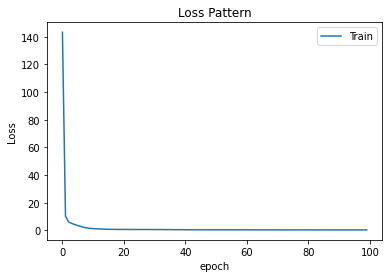

In [12]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [13]:
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = VariationalAutoencoderModel.get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = anomaly_threshold

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

/home/andressa.amaral/.local/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [14]:
test_start = time.time()

X_pred_VAE = vae_model.predict(X_test_VAE)

test_end = time.time()
test_time = test_end - test_start
print("Testing time:", test_time)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = VariationalAutoencoderModel.get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

Testing time: 35.766634464263916
[False False False ...  True  True  True]


0.9476685689695802

In [15]:
print(len(X_test_VAE))

976010


## Metrics

In [16]:
sys.stdout = open("Results/philips_baby_monitor.txt", "a")

print(" ==== Test " + str(number_features) + " Normal learning rate ====")
print("Training time:" + str(train_time))
print("Testing time:" + str(test_time))
print(classification_report(Y_test_VAE, attacks, digits = 5))

In [17]:
'''# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test_VAE)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)'''

'# Examinig the latent space generated by the encoder\n\nX_encoded = encoder.predict(X_test_VAE)\n\npca = PCA(n_components=2)\nX_analysis = pca.fit_transform(X_encoded)'

In [18]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)
plt.grid()
plt.show()

# Darker clusters indicate that the error is higher'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)\nplt.grid()\nplt.show()\n\n# Darker clusters indicate that the error is higher'

In [19]:
'''plt.figure(figsize=(12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)
plt.grid()
plt.show()

# Orange ones are anomalies'''

'plt.figure(figsize=(12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)\nplt.grid()\nplt.show()\n\n# Orange ones are anomalies'

In [20]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)
plt.grid()
plt.show()

# Ground truth'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)\nplt.grid()\nplt.show()\n\n# Ground truth'